In [16]:
%load_ext lab_black
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from scipy.stats import pearsonr

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [17]:
# setup (so this notebook can be run for trait-group repeatedly)
trait = "LDL"
group = "all"
method = "mean+var"
prefix = ""
covar = "PC1"

# This hypothesis can be validated using predictive checks

In [18]:
def regression(trait, group, covar, prefix):
    method = "mean+var"
    df_stats_list = []
    for seed in range(1, 31):
        df = pd.read_csv(
            f"out/{prefix}/model/{trait}-{group}/{seed}-{method}.test_info.tsv",
            sep="\t",
            index_col=0,
        )
        if len(df[covar].unique()) > 5:
            df["q"] = pd.qcut(df[covar], q=5).cat.codes
        else:
            df["q"] = df[covar].values

        df_stats = {
            "r2": [],
            "std(resid)": [],
            "std(pred)": [],
            "std(y)": [],
            "slope": [],
        }

        for i, (q, dfq) in enumerate(df.groupby("q")):
            x, y = dfq["cal_pred"], dfq["pheno"]
            model = sm.OLS(endog=y, exog=sm.add_constant(x)).fit()
            df_stats["r2"].append(model.rsquared)
            df_stats["std(resid)"].append(np.std(model.resid))
            df_stats["std(pred)"].append(np.std(x))
            df_stats["std(y)"].append(np.std(y))

            model = sm.WLS(
                endog=y, exog=sm.add_constant(x), weights=(1 / dfq["cal_predstd"]) ** 2
            ).fit()
            df_stats["slope"].append(model.params[1])

        df_stats = pd.DataFrame(df_stats)
        df_stats_list.append(df_stats)

    df_stats = pd.DataFrame(
        np.mean(df_stats_list, axis=0),
        index=df_stats_list[0].index,
        columns=df_stats_list[0].columns,
    )
    df_stats_sem = pd.DataFrame(
        np.std(df_stats_list, axis=0) / np.sqrt(len(df_stats_list)),
        index=df_stats_list[0].index,
        columns=df_stats_list[0].columns,
    )

    return df_stats, df_stats_sem

In [23]:
df_stats1, df_stats_sem1 = regression(
    trait="LDL", group="all", covar="PC1", prefix="no-interaction"
)
df_stats2, df_stats_sem2 = regression(
    trait="LDL", group="all", covar="PC1", prefix="interaction"
)

In [24]:
df_stats1

,r2,std(resid),std(pred),std(y),slope
0,0.151076,30.834493,13.156819,33.470491,1.060088
1,0.141101,31.236772,13.282199,33.708608,1.012054
2,0.144041,30.817492,13.128346,33.311390,1.035039
3,0.145205,31.095310,13.045626,33.635751,1.032002
4,0.085013,31.261715,12.927646,32.683679,0.791371


In [26]:
df_stats2

,r2,std(resid),std(pred),std(y),slope
0,0.154132,30.779072,13.573971,33.470491,1.016192
1,0.142292,31.215223,13.662334,33.708608,0.967079
2,0.146080,30.780659,13.502409,33.311390,0.990729
3,0.146256,31.076636,12.845474,33.635751,1.029971
4,0.083702,31.284102,11.323160,32.683679,0.879159


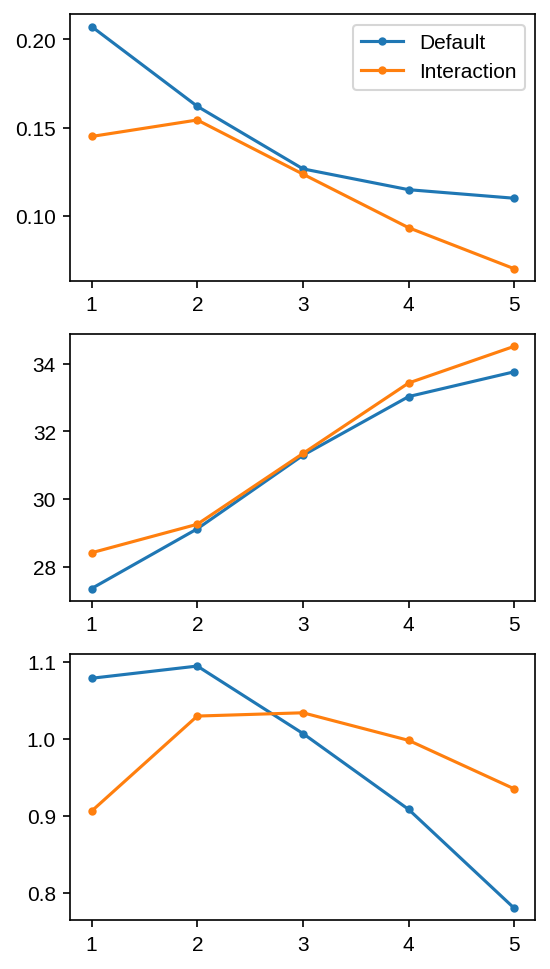

In [158]:
fig, axes = plt.subplots(figsize=(4, 8), dpi=150, nrows=3)

for i, yvar in enumerate(["r2", "std(resid)", "slope"]):
    ax = axes[i]
    ax.errorbar(x=np.arange(5), y=df_stats1[yvar], marker=".", label="Default")
    ax.errorbar(x=np.arange(5), y=df_stats2[yvar], marker=".", label="Interaction")
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(np.arange(1, 6).astype(str))
axes[0].legend()

In [159]:
df_stats1

,r2,std(resid),std(pred),std(y),slope
0,0.207344,27.362425,13.181653,30.736063,1.079328
1,0.162073,29.126385,11.902479,31.822291,1.095193
2,0.126566,31.296628,12.158522,33.490835,1.007501
3,0.114751,33.030927,13.305464,35.109170,0.908814
4,0.109892,33.763172,15.257300,35.790895,0.780305


In [14]:
def predictive_check(trait, group, covar):
    dict_r2 = dict()
    for method in ["mean", "mean+var"]:
        r2_list = []
        for seed in range(1, 31):
            df = pd.read_csv(
                f"out/model/{trait}-{group}/{seed}-{method}.test_info.tsv",
                sep="\t",
                index_col=0,
            )
            df_params = pd.read_csv(
                f"out/model/{trait}-{group}/{seed}-{method}.param.tsv",
                sep="\t",
                index_col=0,
            )
            if len(df[covar].unique()) > 5:
                df["q"] = pd.qcut(df[covar], q=5).cat.codes
            else:
                df["q"] = df[covar].values

            df["pheno_sim"] = np.random.normal(
                loc=df["cal_pred"], scale=df["cal_predstd"]
            )
            r2 = df.groupby("q").apply(
                lambda dfq: stats.pearsonr(dfq["cal_pred"], dfq["pheno_sim"])[0] ** 2
            )
            r2_list.append(r2)
        r2_list = pd.concat(r2_list, axis=1).T
        dict_r2[method] = r2_list

    fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2, sharey=True)
    for i, method in enumerate(["mean", "mean+var"]):
        ax = axes[i]
        ax.boxplot(dict_r2[method], notch=True)
        ax.set_title(method, fontsize=11)
        ax.set_xlabel(covar)
    fig.suptitle(f"{trait}, {group}", y=0.9)
    fig.tight_layout()
    fig.show()

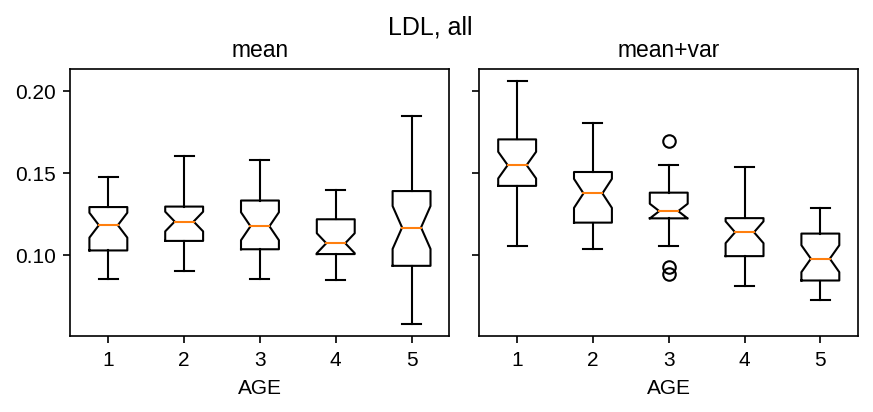

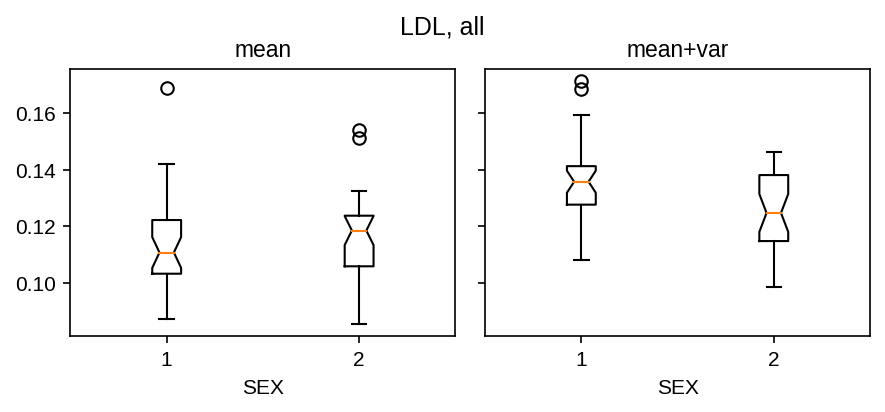

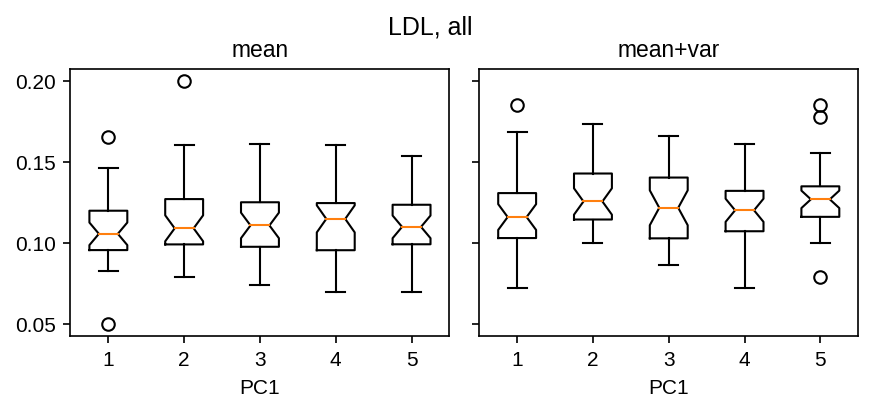

In [15]:
for covar in ["AGE", "SEX", "PC1"]:
    predictive_check(trait="LDL", group="all", covar=covar)

# This can also be validated using numerical evidence

- Stratify regression analysis between $y$ and $\widehat{y}$ across age/sex/PC1
- Stratify regression analysis between $y$ and individual covariates age/sex/PC1 (print top covariates)

In [17]:
trait, group = "LDL", "all"
seed = 1
method = "mean+var"

In [18]:
df_params = pd.read_csv(
    f"out/model/{trait}-{group}/{seed}-{method}.param.tsv",
    sep="\t",
    index_col=0,
)

In [19]:
df_params

,mean_beta,var_beta
const,136.105247,6.890973
PGS,11.308168,0.170092
AGE,2.350215,0.159522
SEX,-2.188543,0.029843
DEPRIVATION_INDEX,-1.149395,0.025229
log_BMI,3.245760,0.106702
income,0.367851,-0.054892
ever_smoked,0.017743,0.039426
drink_alcohol,1.116995,0.008285
PC1,-0.135562,0.038564


In [20]:
for covar in ["PC1", "AGE", "SEX"]:
    print(f"# {covar}")
    df_stats, df_stats_std = regression("LDL", "all", covar)
    display(df_stats)

# PC1


,r2,std(resid),std(fitted_resid),std(pred),std(y),slope
0,0.119262,31.407641,31.425798,11.646144,33.470491,1.068392
1,0.110019,31.797761,31.821022,11.761903,33.708608,1.015626
2,0.118842,31.268764,31.280648,11.670805,33.311390,1.066583
3,0.117146,31.602127,31.614379,11.806545,33.635751,1.029752
4,0.060638,31.676317,31.933631,11.912602,32.683679,0.735557


# AGE


,r2,std(resid),std(fitted_resid),std(pred),std(y),slope
0,0.147260,28.380962,28.393301,11.981957,30.736063,1.009812
1,0.152747,29.287554,29.312518,11.838053,31.822291,1.064837
2,0.120022,31.414231,31.431264,11.816085,33.490835,1.013746
3,0.089650,33.496389,33.530393,11.655263,35.109170,0.931303
4,0.066878,34.570301,34.670940,11.632627,35.790895,0.812150


# SEX


,r2,std(resid),std(fitted_resid),std(pred),std(y),slope
0,0.150901,30.876931,30.898304,12.041375,33.508902,1.129497
1,0.067117,32.317246,32.506184,12.084615,33.460890,0.791723


In [55]:
for covar in ["PC1", "AGE", "SEX"]:
    print(f"# {covar}")
    display(regression("height", "all", covar))

# PC1


,r2,std(resid),std(fitted_resid),std(pred),std(y),slope
0,0.721316,4.878921,4.880902,7.768585,9.245027,1.009872
1,0.723237,4.861613,4.865405,7.798162,9.244801,1.009104
2,0.723341,4.877291,4.879075,7.821458,9.276080,1.007650
3,0.687827,5.164796,5.167314,7.697015,9.250455,0.998640
4,0.627559,5.546394,5.558699,7.499540,9.094314,0.970806


# AGE


,r2,std(resid),std(fitted_resid),std(pred),std(y),slope
0,0.678591,5.300082,5.302531,7.740830,9.352005,1.000957
1,0.690563,5.185700,5.189651,7.763076,9.327650,1.003151
2,0.710328,4.980101,4.982710,7.784548,9.256567,1.003977
3,0.712709,4.941826,4.944707,7.772724,9.225005,1.004160
4,0.708427,4.936730,4.941017,7.777545,9.146055,0.991815


# SEX


,r2,std(resid),std(fitted_resid),std(pred),std(y),slope
0,0.430171,4.897012,4.898766,4.269776,6.487685,0.997218
1,0.426855,5.299673,5.301393,4.571090,7.001232,1.000383
